# Data Preparation 1.1

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Load your data
df = pd.read_csv('synthetic_stock_data.csv')

# Define our states
states = ['Bullish', 'Bearish', 'Stable']
print(f"Available states: {states}")
print(f"Total records: {len(df)}")

Available states: ['Bullish', 'Bearish', 'Stable']
Total records: 1000


## Count State Transitions

In [2]:
def count_transitions(df):
    """
    Count transitions between states across all companies
    """
    transition_counts = defaultdict(lambda: defaultdict(int))
    
    # Group by company to maintain temporal order
    for company in df['Company'].unique():
        company_data = df[df['Company'] == company].sort_values('Date')
        trends = company_data['Trend'].tolist()
        
        # Count transitions for this company
        for i in range(len(trends) - 1):
            current_state = trends[i]
            next_state = trends[i + 1]
            transition_counts[current_state][next_state] += 1
    
    return transition_counts

# Get transition counts
transition_counts = count_transitions(df)
print("Transition Counts:")
for from_state in states:
    for to_state in states:
        count = transition_counts[from_state][to_state]
        print(f"  {from_state} → {to_state}: {count}")

Transition Counts:
  Bullish → Bullish: 106
  Bullish → Bearish: 98
  Bullish → Stable: 107
  Bearish → Bullish: 106
  Bearish → Bearish: 97
  Bearish → Stable: 101
  Stable → Bullish: 100
  Stable → Bearish: 106
  Stable → Stable: 116


## Build Transition Probability Matrix

In [3]:
def build_transition_matrix(transition_counts, states):
    """
    Convert counts to probabilities
    """
    n_states = len(states)
    transition_matrix = np.zeros((n_states, n_states))
    
    # Create state to index mapping
    state_to_idx = {state: idx for idx, state in enumerate(states)}
    
    # Fill the matrix with probabilities
    for i, from_state in enumerate(states):
        total_from = sum(transition_counts[from_state].values())
        
        for j, to_state in enumerate(states):
            if total_from > 0:
                transition_matrix[i][j] = transition_counts[from_state][to_state] / total_from
            else:
                transition_matrix[i][j] = 0
    
    return transition_matrix, state_to_idx

# Build the 3x3 transition matrix
transition_matrix, state_to_idx = build_transition_matrix(transition_counts, states)

print("\nTransition Probability Matrix (3x3):")
print("Rows: [Bullish, Bearish, Stable]")
print("Columns: [Bullish, Bearish, Stable]")
print("\n" + "="*50)
for i, from_state in enumerate(states):
    row = [f"{transition_matrix[i][j]:.3f}" for j in range(len(states))]
    print(f"{from_state:>8} → [ {', '.join(row)} ]")


Transition Probability Matrix (3x3):
Rows: [Bullish, Bearish, Stable]
Columns: [Bullish, Bearish, Stable]

 Bullish → [ 0.341, 0.315, 0.344 ]
 Bearish → [ 0.349, 0.319, 0.332 ]
  Stable → [ 0.311, 0.329, 0.360 ]


## Validate the Matrix

In [4]:
def validate_transition_matrix(transition_matrix):
    """
    Check if each row sums to 1 (proper probability distribution)
    """
    print("\n" + "="*50)
    print("VALIDATION:")
    print("="*50)
    
    for i, state in enumerate(states):
        row_sum = np.sum(transition_matrix[i])
        print(f"{state} row sum: {row_sum:.6f} {'✓' if abs(row_sum - 1.0) < 0.0001 else '✗'}")
    
    print(f"\nMatrix Shape: {transition_matrix.shape}")
    print(f"Dimension: {transition_matrix.shape[0]}x{transition_matrix.shape[1]}")

validate_transition_matrix(transition_matrix)


VALIDATION:
Bullish row sum: 1.000000 ✓
Bearish row sum: 1.000000 ✓
Stable row sum: 1.000000 ✓

Matrix Shape: (3, 3)
Dimension: 3x3


## Markov Chain Simulation & Prediction

In [5]:
def predict_next_state(current_state, transition_matrix, state_to_idx):
    """
    Predict the next state given current state
    """
    current_idx = state_to_idx[current_state]
    probabilities = transition_matrix[current_idx]
    
    # Get the most likely next state
    next_idx = np.argmax(probabilities)
    next_state = states[next_idx]
    confidence = probabilities[next_idx]
    
    return next_state, confidence

def simulate_markov_chain(initial_state, transition_matrix, state_to_idx, steps=5):
    """
    Simulate multiple steps of the Markov chain
    """
    current_state = initial_state
    path = [current_state]
    
    print(f"\nMARKOV CHAIN SIMULATION (Starting from: {initial_state})")
    print("="*40)
    
    for step in range(steps):
        next_state, confidence = predict_next_state(current_state, transition_matrix, state_to_idx)
        print(f"Step {step+1}: {current_state} → {next_state} (confidence: {confidence:.3f})")
        current_state = next_state
        path.append(current_state)
    
    return path

# Example usage
current_market_state = "Bullish"  # You can change this
simulation_path = simulate_markov_chain(current_market_state, transition_matrix, state_to_idx)


MARKOV CHAIN SIMULATION (Starting from: Bullish)
Step 1: Bullish → Stable (confidence: 0.344)
Step 2: Stable → Stable (confidence: 0.360)
Step 3: Stable → Stable (confidence: 0.360)
Step 4: Stable → Stable (confidence: 0.360)
Step 5: Stable → Stable (confidence: 0.360)


## Steady-State Analysis

In [6]:
def find_steady_state(transition_matrix, tolerance=1e-8, max_iterations=1000):
    """
    Find the steady-state distribution (long-term probabilities)
    """
    n_states = transition_matrix.shape[0]
    # Start with uniform distribution
    steady = np.ones(n_states) / n_states
    
    for i in range(max_iterations):
        new_steady = steady @ transition_matrix
        if np.max(np.abs(new_steady - steady)) < tolerance:
            break
        steady = new_steady
    
    return steady

steady_state = find_steady_state(transition_matrix)
print("\n" + "="*50)
print("STEADY-STATE DISTRIBUTION (Long-term probabilities):")
print("="*50)
for i, state in enumerate(states):
    print(f"{state}: {steady_state[i]:.4f} ({steady_state[i]*100:.2f}%)")


STEADY-STATE DISTRIBUTION (Long-term probabilities):
Bullish: 0.3329 (33.29%)
Bearish: 0.3213 (32.13%)
Stable: 0.3459 (34.59%)


## Transition Matrix Heatmap

🔥 BLOCK 1: Transition Matrix Heatmap


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_25832\2373070911.py:61: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


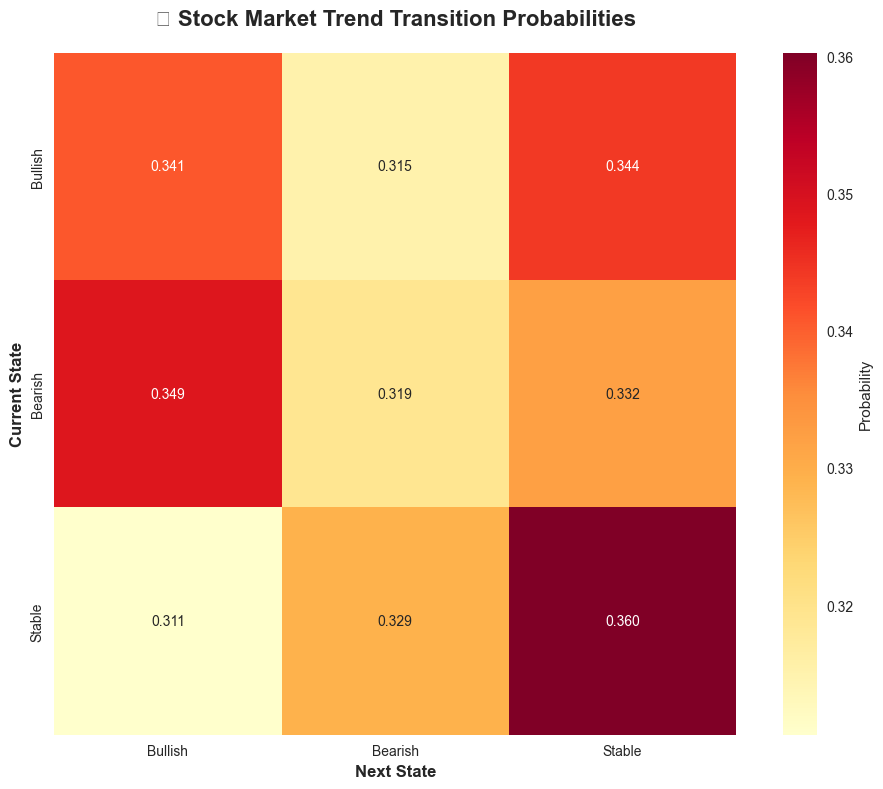

✅ Heatmap generated successfully!
Matrix shape: (3, 3)



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set up styling
plt.style.use('seaborn-v0_8')

def build_markov_model(df):
    """Build the Markov model (needed for all visuals)"""
    states = ['Bullish', 'Bearish', 'Stable']
    
    # Count transitions
    transition_counts = defaultdict(lambda: defaultdict(int))
    
    for company in df['Company'].unique():
        company_data = df[df['Company'] == company].sort_values('Date')
        trends = company_data['Trend'].tolist()
        
        for i in range(len(trends) - 1):
            current_state = trends[i]
            next_state = trends[i + 1]
            transition_counts[current_state][next_state] += 1
    
    # Build transition matrix
    n_states = len(states)
    transition_matrix = np.zeros((n_states, n_states))
    state_to_idx = {state: idx for idx, state in enumerate(states)}
    
    for i, from_state in enumerate(states):
        total_from = sum(transition_counts[from_state].values())
        for j, to_state in enumerate(states):
            if total_from > 0:
                transition_matrix[i][j] = transition_counts[from_state][to_state] / total_from
    
    return transition_matrix, states, state_to_idx, transition_counts

# Load data
df = pd.read_csv('synthetic_stock_data.csv')
transition_matrix, states, state_to_idx, transition_counts = build_markov_model(df)

# BLOCK 1: HEATMAP VISUALIZATION
print("🔥 BLOCK 1: Transition Matrix Heatmap")
print("="*50)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(transition_matrix, 
                xticklabels=states, 
                yticklabels=states,
                annot=True, 
                fmt='.3f', 
                cmap='YlOrRd',
                cbar_kws={'label': 'Probability'},
                square=True)

plt.title('🎲 Stock Market Trend Transition Probabilities', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Next State', fontsize=12, fontweight='bold')
plt.ylabel('Current State', fontsize=12, fontweight='bold')
ax.set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

print("✅ Heatmap generated successfully!")
print(f"Matrix shape: {transition_matrix.shape}")
print("\n" + "="*50)

## State Transition Diagram

🔄 BLOCK 2: State Transition Diagram


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_25832\171977127.py:77: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


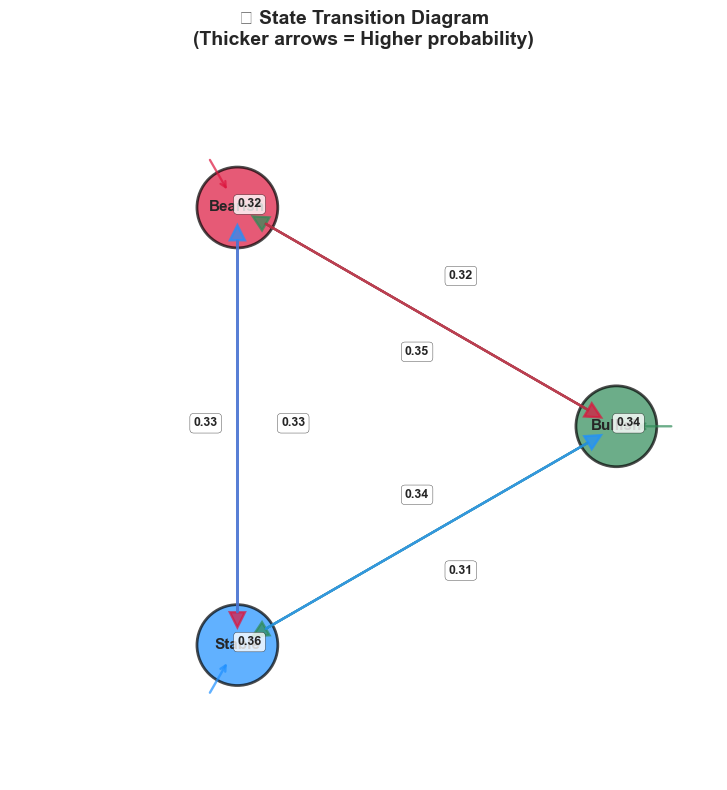

✅ State transition diagram generated!
💡 Thicker arrows indicate higher transition probabilities



In [8]:
# BLOCK 2: STATE TRANSITION DIAGRAM
print("🔄 BLOCK 2: State Transition Diagram")
print("="*50)

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#2E8B57', '#DC143C', '#1E90FF']  # Green, Red, Blue

# Node positions (circular layout)
angles = np.linspace(0, 2*np.pi, len(states), endpoint=False)
radius = 5
node_positions = {}

for i, state in enumerate(states):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    node_positions[state] = (x, y)
    
    # Draw nodes
    circle = plt.Circle((x, y), 0.8, color=colors[i], alpha=0.7, ec='black', lw=2)
    ax.add_patch(circle)
    plt.text(x, y, state, ha='center', va='center', fontweight='bold', fontsize=11)

# Draw transitions (arrows)
for i, from_state in enumerate(states):
    for j, to_state in enumerate(states):
        prob = transition_matrix[i][j]
        if prob > 0.01:  # Only show meaningful probabilities
            start_pos = node_positions[from_state]
            end_pos = node_positions[to_state]
            
            # Adjust arrow for self-loops
            if from_state == to_state:
                # Create curved self-loop
                control_distance = 1.5
                angle = angles[i]
                control_x = start_pos[0] + control_distance * np.cos(angle)
                control_y = start_pos[1] + control_distance * np.sin(angle)
                
                # Draw curved arrow (simplified)
                plt.annotate('', xy=start_pos, xytext=(control_x, control_y),
                           arrowprops=dict(arrowstyle='->', 
                                         color=colors[i], 
                                         lw=2*prob + 1,
                                         alpha=0.7,
                                         shrinkA=15, shrinkB=15))
            else:
                # Straight arrow between different states
                dx = end_pos[0] - start_pos[0]
                dy = end_pos[1] - start_pos[1]
                shorten = 0.85
                start_x = start_pos[0] + dx * (1 - shorten) / 2
                start_y = start_pos[1] + dy * (1 - shorten) / 2
                end_x = end_pos[0] - dx * (1 - shorten) / 2
                end_y = end_pos[1] - dy * (1 - shorten) / 2
                
                plt.arrow(start_x, start_y, dx*shorten, dy*shorten,
                        head_width=0.3, head_length=0.3, 
                        fc=colors[i], ec=colors[i],
                        alpha=0.7, lw=2*prob + 1)
            
            # Add probability labels
            mid_x = (start_pos[0] + end_pos[0]) / 2
            mid_y = (start_pos[1] + end_pos[1]) / 2
            label_x = mid_x + 0.5 * (end_pos[1] - start_pos[1]) / radius
            label_y = mid_y + 0.5 * (start_pos[0] - end_pos[0]) / radius
            
            plt.text(label_x, label_y, f'{prob:.2f}', 
                    fontsize=9, fontweight='bold', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

ax.set_xlim(-radius-2, radius+2)
ax.set_ylim(-radius-2, radius+2)
ax.set_aspect('equal')
plt.axis('off')
plt.title('🔄 State Transition Diagram\n(Thicker arrows = Higher probability)', 
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✅ State transition diagram generated!")
print("💡 Thicker arrows indicate higher transition probabilities")
print("\n" + "="*50)        

## Transition Statistics

📊 BLOCK 3: Transition Statistics


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_25832\2459359918.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

c:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


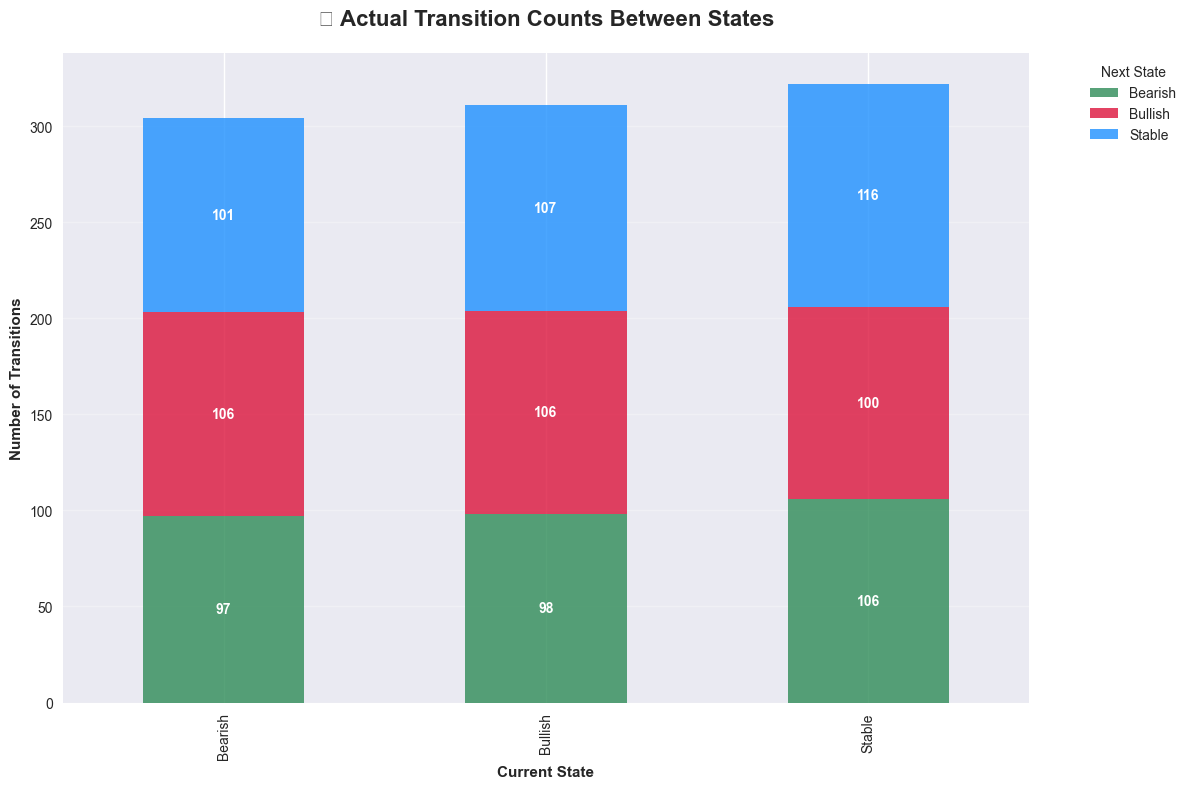


📈 TRANSITION STATISTICS SUMMARY:
------------------------------
Total transitions analyzed: 937

Bullish:
  → Bullish: 106 transitions ( 34.1%)
  → Bearish: 98 transitions ( 31.5%)
  → Stable: 107 transitions ( 34.4%)

Bearish:
  → Bullish: 106 transitions ( 34.9%)
  → Bearish: 97 transitions ( 31.9%)
  → Stable: 101 transitions ( 33.2%)

Stable:
  → Bullish: 100 transitions ( 31.1%)
  → Bearish: 106 transitions ( 32.9%)
  → Stable: 116 transitions ( 36.0%)



In [9]:
# BLOCK 3: TRANSITION STATISTICS
print("📊 BLOCK 3: Transition Statistics")
print("="*50)

# Prepare data for stacked bar chart
from_data = []
to_data = []
count_data = []

for from_state in states:
    for to_state in states:
        from_data.append(from_state)
        to_data.append(to_state)
        count_data.append(transition_counts[from_state][to_state])

stats_df = pd.DataFrame({
    'From': from_data,
    'To': to_data,
    'Count': count_data
})

# Create stacked bar chart
plt.figure(figsize=(12, 8))
pivot_df = stats_df.pivot(index='From', columns='To', values='Count')
ax = pivot_df.plot(kind='bar', stacked=True, color=colors, 
                  figsize=(12, 8), alpha=0.8)

plt.title('📊 Actual Transition Counts Between States', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Current State', fontweight='bold')
plt.ylabel('Number of Transitions', fontweight='bold')
plt.legend(title='Next State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Print some statistics
print("\n📈 TRANSITION STATISTICS SUMMARY:")
print("-" * 30)
total_transitions = sum(count_data)
print(f"Total transitions analyzed: {total_transitions}")

for from_state in states:
    total_from = sum(transition_counts[from_state].values())
    print(f"\n{from_state}:")
    for to_state in states:
        count = transition_counts[from_state][to_state]
        if count > 0:
            percentage = (count / total_from) * 100
            print(f"  → {to_state}: {count:2d} transitions ({percentage:5.1f}%)")

print("\n" + "="*50)

## Prediction Confidence Charts

🎯 BLOCK 4: Prediction Confidence Charts

📊 Analyzing: Bullish


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_25832\3225987390.py:28: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


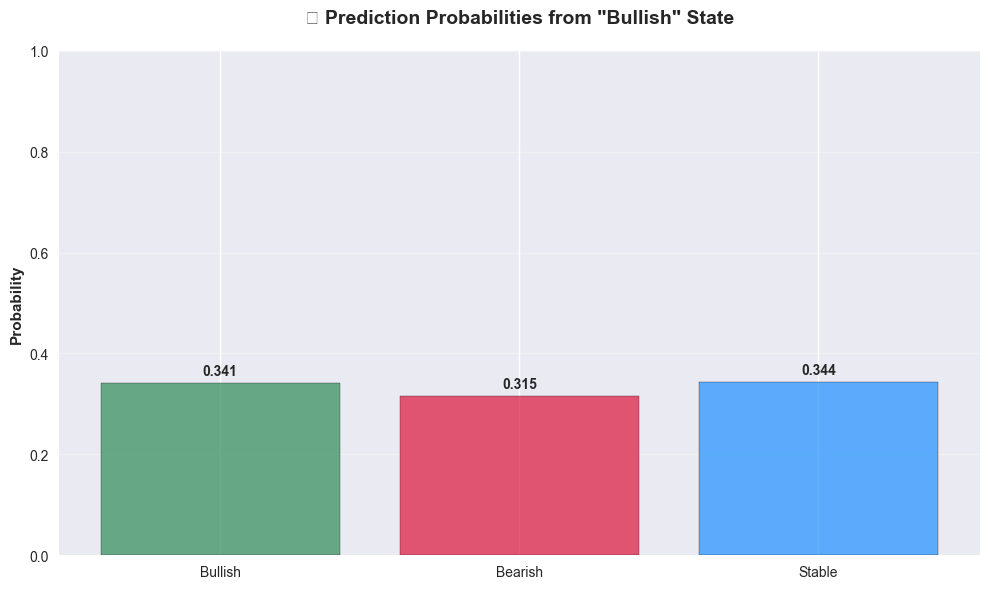

📈 Prediction: Bullish → Stable (34.4% confidence)

📊 Analyzing: Bearish


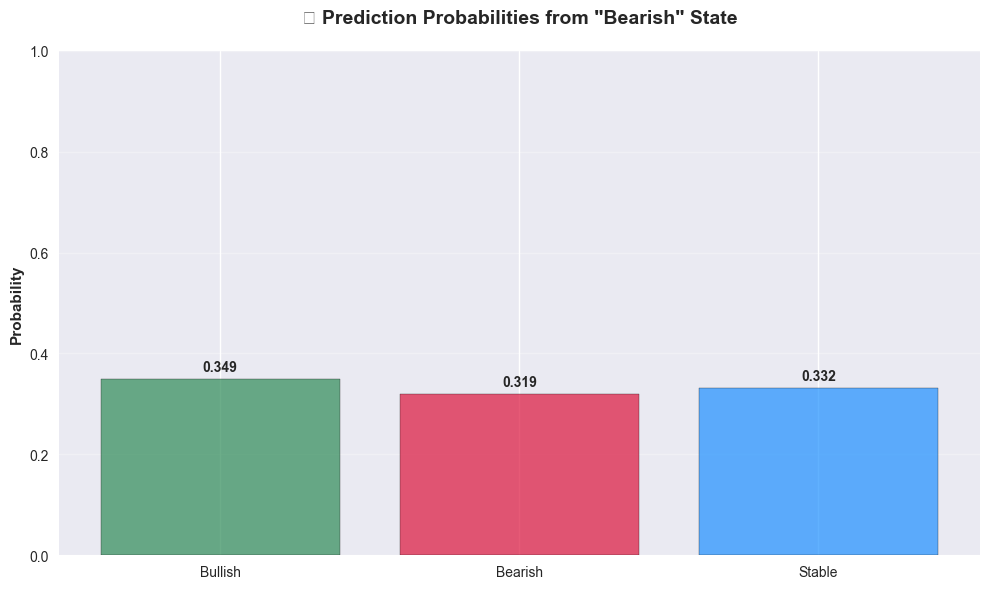

📈 Prediction: Bearish → Bullish (34.9% confidence)

📊 Analyzing: Stable


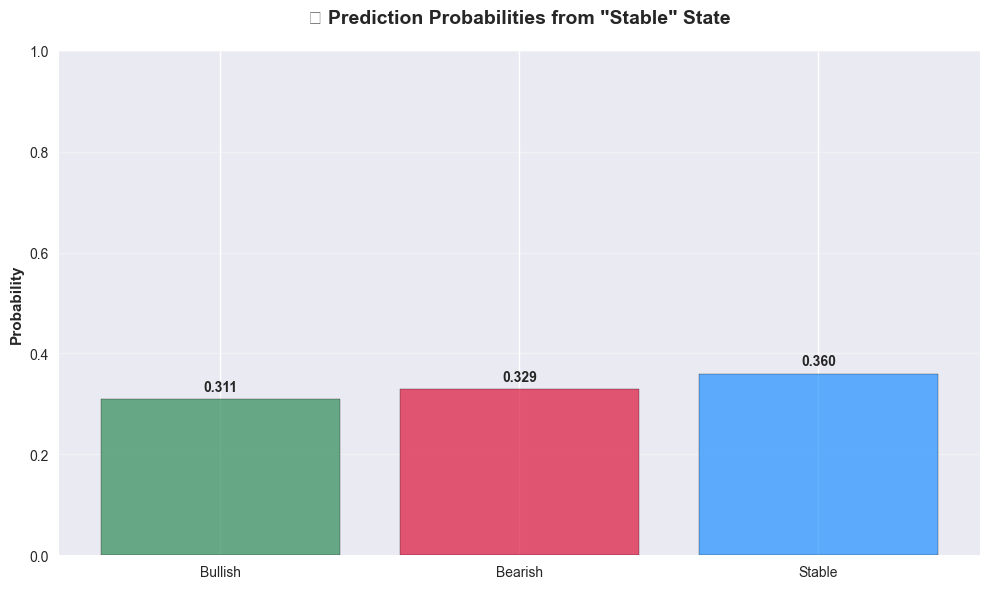

📈 Prediction: Stable → Stable (36.0% confidence)



In [10]:
# BLOCK 4: PREDICTION CONFIDENCE CHARTS
print("🎯 BLOCK 4: Prediction Confidence Charts")
print("="*50)

def plot_state_predictions(current_state):
    """Plot confidence levels for a specific state"""
    if current_state not in state_to_idx:
        print(f"❌ Invalid state. Choose from {states}")
        return
    
    current_idx = state_to_idx[current_state]
    probabilities = transition_matrix[current_idx]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(states, probabilities, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'🎯 Prediction Probabilities from "{current_state}" State', 
             fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Probability', fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print prediction
    next_idx = np.argmax(probabilities)
    next_state = states[next_idx]
    confidence = probabilities[next_idx]
    print(f"📈 Prediction: {current_state} → {next_state} ({confidence:.1%} confidence)")

# Generate confidence charts for each state
for state in states:
    print(f"\n📊 Analyzing: {state}")
    plot_state_predictions(state)

print("\n" + "="*50)

## Market Trend Simulation

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_25832\1744845085.py:55: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Arial.
  plt.tight_layout()


🔮 BLOCK 5: Market Trend Simulation
🚀 Running Market Simulations...


📋 Case: Optimistic Market Start
🎯 Starting state: Bullish


c:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


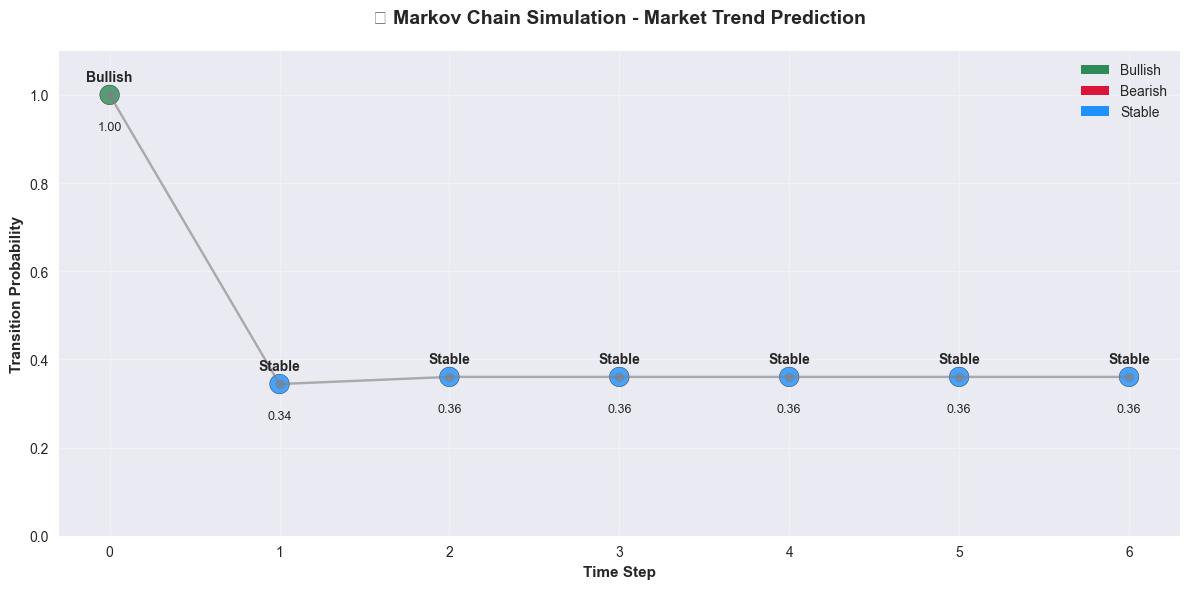

📈 Simulation path: Bullish → Stable → Stable → Stable → Stable → Stable → Stable
📊 Probabilities: ['1.00', '0.34', '0.36', '0.36', '0.36', '0.36', '0.36']
--------------------------------------------------

📋 Case: Pessimistic Market Start
🎯 Starting state: Bearish


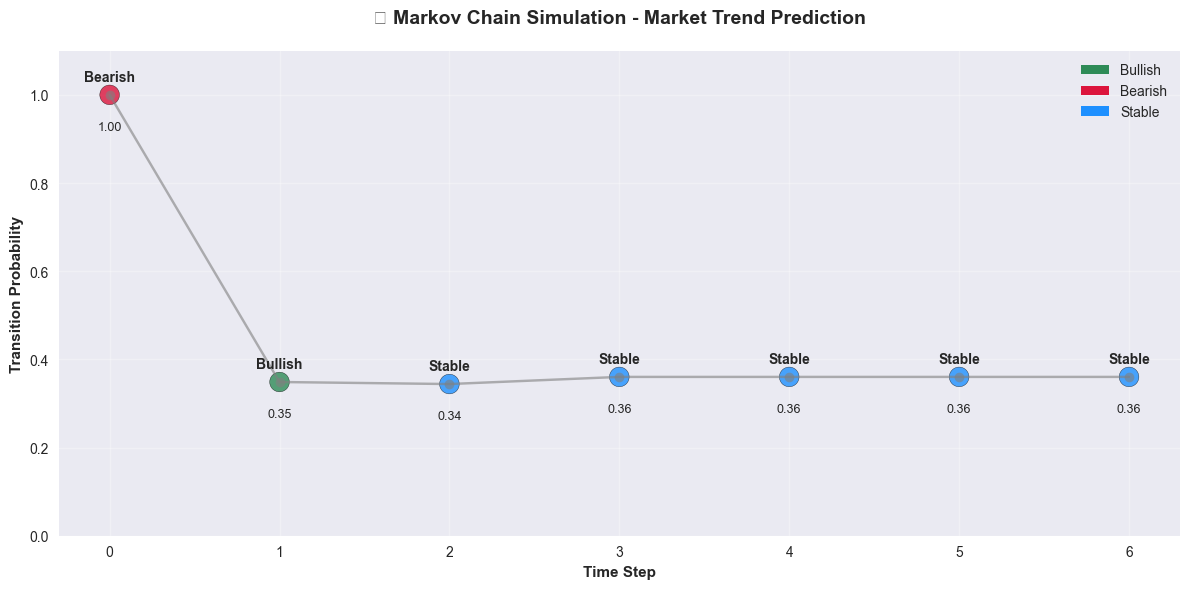

📈 Simulation path: Bearish → Bullish → Stable → Stable → Stable → Stable → Stable
📊 Probabilities: ['1.00', '0.35', '0.34', '0.36', '0.36', '0.36', '0.36']
--------------------------------------------------

📋 Case: Neutral Market Start
🎯 Starting state: Stable


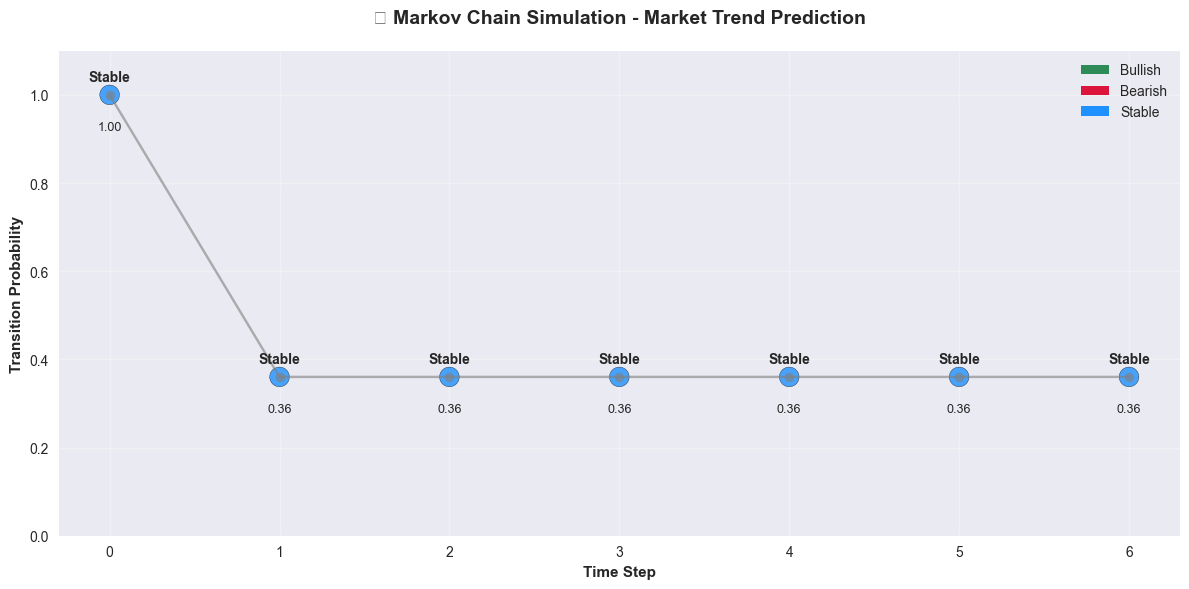

📈 Simulation path: Stable → Stable → Stable → Stable → Stable → Stable → Stable
📊 Probabilities: ['1.00', '0.36', '0.36', '0.36', '0.36', '0.36', '0.36']
--------------------------------------------------

✅ All visualizations completed successfully!
🎨 You now have 5 independent visualization blocks!


In [11]:
# BLOCK 5: MARKET TREND SIMULATION
print("🔮 BLOCK 5: Market Trend Simulation")
print("="*50)

def simulate_markov_chain(initial_state, steps=10):
    """Visualize a Markov chain simulation"""
    if initial_state not in state_to_idx:
        print(f"❌ Invalid initial state. Choose from {states}")
        return
    
    current_state = initial_state
    path = [current_state]
    probabilities = [1.0]  # Initial state has 100% probability
    
    # Run simulation
    for step in range(steps):
        current_idx = state_to_idx[current_state]
        next_probs = transition_matrix[current_idx]
        next_idx = np.argmax(next_probs)
        current_state = states[next_idx]
        path.append(current_state)
        probabilities.append(next_probs[next_idx])
    
    # Create simulation plot
    plt.figure(figsize=(12, 6))
    
    # Color each point based on state
    colors_path = [colors[states.index(state)] for state in path]
    
    plt.plot(range(len(path)), probabilities, 'o-', alpha=0.6, color='gray')
    scatter = plt.scatter(range(len(path)), probabilities, c=colors_path, 
                        s=200, alpha=0.8, edgecolors='black')
    
    # Add labels and annotations
    for i, (state, prob) in enumerate(zip(path, probabilities)):
        plt.annotate(state, (i, prob), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontweight='bold')
        plt.annotate(f'{prob:.2f}', (i, prob), textcoords="offset points", 
                    xytext=(0,-25), ha='center', fontsize=9)
    
    plt.title('🔮 Markov Chain Simulation - Market Trend Prediction', 
             fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Time Step', fontweight='bold')
    plt.ylabel('Transition Probability', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(len(path)))
    plt.ylim(0, 1.1)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], label=states[i]) 
                     for i in range(len(states))]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return path, probabilities

# Run simulations for different starting states
print("🚀 Running Market Simulations...\n")

simulation_cases = [
    ("Bullish", "Optimistic Market Start"),
    ("Bearish", "Pessimistic Market Start"), 
    ("Stable", "Neutral Market Start")
]

for initial_state, description in simulation_cases:
    print(f"\n📋 Case: {description}")
    print(f"🎯 Starting state: {initial_state}")
    
    path, probs = simulate_markov_chain(initial_state, steps=6)
    
    print(f"📈 Simulation path: {' → '.join(path)}")
    print(f"📊 Probabilities: {[f'{p:.2f}' for p in probs]}")
    print("-" * 50)

print("\n" + "="*50)
print("✅ All visualizations completed successfully!")
print("🎨 You now have 5 independent visualization blocks!")

In [12]:
# annimation of markov chain simulation
# ADVANCED ANIMATION: MULTIPLE SIMULTANEOUS PATHS
print("\n🌟 ADVANCED: Multiple Path Animation")
print("="*50)

import warnings
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib import cm

def _ensure_external_backend():
    """Try to switch to an interactive backend so the animation pops out."""
    preferred_backends = ['qt5agg', 'tkagg']
    current_backend = mpl.get_backend().lower()
    inline_token = 'matplotlib_inline' in current_backend
    if not inline_token:
        return current_backend
    last_error = None
    for backend in preferred_backends:
        try:
            plt.switch_backend(backend)
            print(f"🪟 Switched matplotlib backend to '{backend}' for pop-out rendering.")
            return backend
        except Exception as err:
            last_error = err
            warnings.warn(f"Could not enable backend '{backend}': {err}")
    warnings.warn(
        "Falling back to inline backend. Animation will stay inside the notebook."
    )
    if last_error:
        print(f"⚠️ Last backend error: {last_error}")
    return current_backend

_active_backend = _ensure_external_backend()

def create_multiple_path_animation(initial_states, steps=8, rng_seed=None):
    """Create animation showing multiple simultaneous Markov chain paths with diagnostics."""
    rng = np.random.default_rng(rng_seed)
    fig = plt.figure(figsize=(18, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[2.4, 1], height_ratios=[1, 1])
    ax_paths = fig.add_subplot(gs[:, 0])
    ax_distribution = fig.add_subplot(gs[0, 1])
    ax_heatmap = fig.add_subplot(gs[1, 1])

    manager = plt.get_current_fig_manager()
    if manager:
        try:
            manager.set_window_title("Markov Chain – Multi-Path Monitor")
        except Exception:
            pass

    trail_length = steps + 1
    paths = []
    current_steps = np.zeros(len(initial_states), dtype=int)
    transition_counts = np.zeros_like(transition_matrix)
    avg_conf_history = []

    path_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i, init_state in enumerate(initial_states):
        paths.append({
            'current_state': init_state,
            'path': [init_state],
            'probabilities': [1.0],
            'color': path_colors[i % len(path_colors)],
            'label': f'Path {i+1} ({init_state})'
        })

    ax_paths.set_xlim(-0.5, steps + 0.5)
    ax_paths.set_ylim(0, 1.05)
    ax_paths.set_xlabel('Time Step', fontweight='bold')
    ax_paths.set_ylabel('Transition Probability', fontweight='bold')
    ax_paths.set_title('🔮 Multiple Markov Chain Paths', fontsize=14, fontweight='bold')
    ax_paths.grid(True, alpha=0.25)

    avg_conf_line, = ax_paths.plot([], [], '--', color='#333333', linewidth=1.5,
                                   label='Mean confidence')
    path_lines = []
    path_scatters = []

    for path_data in paths:
        line, = ax_paths.plot([], [], 'o-', color=path_data['color'],
                              markersize=6, label=path_data['label'], alpha=0.75)
        scatter = ax_paths.scatter([], [], s=110, color=path_data['color'],
                                   alpha=0.9, edgecolors='black')
        path_lines.append(line)
        path_scatters.append(scatter)

    ax_paths.legend(loc='upper right', ncol=2, fontsize=9)

    ax_distribution.set_xlim(-0.5, len(states) - 0.5)
    ax_distribution.set_ylim(0, 1.0)
    ax_distribution.set_xlabel('Market States', fontweight='bold')
    ax_distribution.set_ylabel('Probability', fontweight='bold')
    ax_distribution.set_title('Current State Distribution vs Steady State',
                              fontsize=12, fontweight='bold')
    ax_distribution.set_xticks(range(len(states)))
    ax_distribution.set_xticklabels(states)
    ax_distribution.grid(True, alpha=0.3, axis='y')

    state_bars = ax_distribution.bar(range(len(states)),
                                     [0]*len(states),
                                     color=['#2E8B57', '#DC143C', '#1E90FF'],
                                     alpha=0.75)
    steady_line = ax_distribution.hlines(steady_state, xmin=np.arange(len(states)) - 0.35,
                                         xmax=np.arange(len(states)) + 0.35,
                                         colors='gray', linestyles='dashed',
                                         label='Steady-state')
    ax_distribution.legend(loc='upper right', fontsize=9)

    heatmap = ax_heatmap.imshow(np.zeros_like(transition_matrix),
                                cmap=cm.cividis, vmin=0, vmax=1, animated=True)
    cbar = fig.colorbar(heatmap, ax=ax_heatmap, fraction=0.046, pad=0.04)
    cbar.set_label('Observed transition probability', fontweight='bold')
    ax_heatmap.set_xticks(range(len(states)))
    ax_heatmap.set_xticklabels(states, rotation=45, ha='right')
    ax_heatmap.set_yticks(range(len(states)))
    ax_heatmap.set_yticklabels(states)
    ax_heatmap.set_title('Dynamic Transition Tracker', fontsize=12, fontweight='bold')
    heatmap_texts = {}
    for i, from_state in enumerate(states):
        for j, to_state in enumerate(states):
            heatmap_texts[(i, j)] = ax_heatmap.text(
                j, i, "0.00", ha='center', va='center',
                color='white', fontsize=9, fontweight='bold'
            )

    info_text = ax_paths.text(0.02, 0.98, '', transform=ax_paths.transAxes, fontsize=10,
                              bbox=dict(facecolor='white', alpha=0.8), va='top')

    def update_heatmap():
        row_sums = transition_counts.sum(axis=1, keepdims=True)
        normalized = np.divide(
            transition_counts,
            row_sums,
            out=np.zeros_like(transition_counts, dtype=float),
            where=row_sums != 0
        )
        heatmap.set_data(normalized)
        vmax = max(0.05, normalized.max())
        heatmap.set_clim(0, vmax)
        for (i, j), text in heatmap_texts.items():
            text.set_text(f"{normalized[i, j]:.2f}")
        return normalized

    def init():
        avg_conf_line.set_data([], [])
        for line in path_lines:
            line.set_data([], [])
        for scatter in path_scatters:
            scatter.set_offsets(np.empty((0, 2)))
        for bar in state_bars:
            bar.set_height(0)
        info_text.set_text('Initializing...')
        heatmap.set_data(np.zeros_like(transition_matrix))
        for text in heatmap_texts.values():
            text.set_text("0.00")
        return path_lines + path_scatters + [avg_conf_line, info_text, heatmap]

    def animate(frame):
        nonlocal transition_counts
        state_counts = {state: 0 for state in states}

        for i, path_data in enumerate(paths):
            if current_steps[i] < steps and frame >= current_steps[i]:
                prev_state = path_data['current_state']
                current_idx = state_to_idx[prev_state]
                next_probs = transition_matrix[current_idx]
                next_idx = rng.choice(len(states), p=next_probs)
                path_data['current_state'] = states[next_idx]

                path_data['path'].append(path_data['current_state'])
                path_data['path'] = path_data['path'][-trail_length:]
                path_data['probabilities'].append(next_probs[next_idx])
                path_data['probabilities'] = path_data['probabilities'][-trail_length:]
                current_steps[i] += 1
                transition_counts[current_idx, next_idx] += 1

            x_data = list(range(len(path_data['probabilities'])))
            path_lines[i].set_data(x_data, path_data['probabilities'])

            if x_data:
                path_scatters[i].set_offsets(
                    np.array([[x_data[-1], path_data['probabilities'][-1]]])
                )

            state_counts[path_data['current_state']] += 1

        last_probs = [p['probabilities'][-1] for p in paths if p['probabilities']]
        if last_probs:
            avg_conf_history.append(float(np.mean(last_probs)))
            avg_conf_line.set_data(range(len(avg_conf_history)), avg_conf_history)

        total_paths = len(paths)
        for j, state in enumerate(states):
            ratio = state_counts[state] / total_paths if total_paths else 0
            state_bars[j].set_height(ratio)

        normalized = update_heatmap()

        current_step = min(current_steps) if len(current_steps) else 0
        info_text.set_text(
            f"Step: {current_step}/{steps}\n"
            f"Active paths: {sum(step < steps for step in current_steps)}\n"
            f"Max observed transition: {normalized.max():.2f}"
        )

        artists = path_lines + path_scatters + [avg_conf_line, info_text, heatmap]
        return artists + list(state_bars)

    anim = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=steps + 4, interval=750, blit=False, repeat=False
    )

    fig.tight_layout()
    return anim

print("🔄 Creating multiple path animation...")
initial_states = ["Bullish", "Bearish", "Stable", "Bullish", "Stable"]
multi_anim = create_multiple_path_animation(initial_states, steps=10, rng_seed=None)

print(f"🪟 Backend in use: {_active_backend}")
print("🚀 Launching animation window (close it to continue execution)...")
plt.show(block=True)

print("✅ Advanced animation completed!")
print("\n" + "="*50)
print("🎉 All animated Markov chain simulations are ready!")
print("💡 Tips: Use multi_anim.save('filename.gif', dpi=120) with the new backend")
print("       Adjust 'interval' parameter to control animation speed")
print("       Increase 'steps' for longer sequences")



🌟 ADVANCED: Multiple Path Animation
🪟 Switched matplotlib backend to 'tkagg' for pop-out rendering.
🔄 Creating multiple path animation...
🪟 Backend in use: tkagg
🚀 Launching animation window (close it to continue execution)...


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_25832\3187932282.py:26: UserWarning: Could not enable backend 'qt5agg': Failed to import any of the following Qt binding modules: PyQt5, PySide2
  warnings.warn(f"Could not enable backend '{backend}': {err}")
C:\Users\Mohamed\AppData\Local\Temp\ipykernel_25832\3187932282.py:216: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Arial.
  fig.tight_layout()
c:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py:861: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Arial.
  func(*args)


✅ Advanced animation completed!

🎉 All animated Markov chain simulations are ready!
💡 Tips: Use multi_anim.save('filename.gif', dpi=120) with the new backend
       Adjust 'interval' parameter to control animation speed
       Increase 'steps' for longer sequences
